# Filters

By Evgenia "Jenny" Nitishinskaya, Dr. Aidan O'Mahony, and Delaney Granizo-Mackenzie. Algorithms by David Edwards.

Kalman Filter Beta Estimation Example from [Dr. Aidan O'Mahony's blog.](http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/)

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

In [15]:
from SimPEG import *
%pylab inline
# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Toy example: falling ball

Imagine we have a falling ball whose motion we are tracking with a camera. The state of the ball consists of its position and velocity. We know that we have the relationship $x_t = x_{t-1} + v_{t-1}\tau - \frac{1}{2} g \tau^2$, where $\tau$ is the time (in seconds) elapsed between $t-1$ and $t$ and $g$ is gravitational acceleration. Meanwhile, our camera can tell us the position of the ball every second, but we know from the manufacturer that the camera accuracy, translated into the position of the ball, implies variance in the position estimate of about 3 meters.

In order to use a Kalman filter, we need to give it transition and observation matrices, transition and observation covariance matrices, and the initial state. The state of the system is (position, velocity), so it follows the transition matrix
$$ \left( \begin{array}{cc}
1 & \tau \\
0 & 1 \end{array} \right) $$

with offset $(-\tau^2 \cdot g/2, -\tau\cdot g)$. The observation matrix just extracts the position coordinate, (1  0), since we are measuring position. We know that the observation variance is 1, and transition covariance is 0 since we will be simulating the data the same way we specified our model. For the inital state, let's feed our model something bogus like (30, 10) and see how our system evolves.

In [16]:
tau = 0.1

# Set up the filter
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # position is 1-dimensional, (x,v) is 2-dimensional
                  initial_state_mean=[30,10],
                  initial_state_covariance=np.eye(2),
                  transition_matrices=[[1,tau], [0,1]],
                  observation_matrices=[[1,0]],
                  observation_covariance=3,
                  transition_covariance=np.zeros((2,2)),
                  transition_offsets=[-4.9*tau**2, -9.8*tau])

In [17]:
# Create a simulation of a ball falling for 40 units of time (each of length tau)
times = np.arange(40)
actual = -4.9*tau**2*times**2

# Simulate the noisy camera data
sim = actual + 3*np.random.randn(40)

# Run filter on camera data
state_means, state_covs = kf.filter(sim)

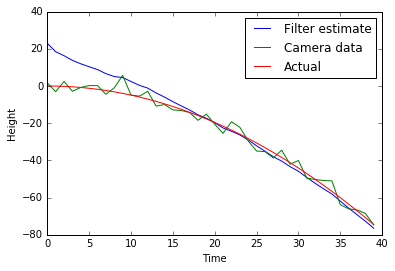

In [18]:
plt.plot(times, state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Filter estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

In [19]:
print(times)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [20]:
print(state_means[:,0])

[ 22.90866398  18.42013824  16.28352774  13.77538728  11.92328042
  10.35074305   8.82132951   6.65263006   5.07145031   4.5407547
   2.43346275   0.37088762  -1.14172     -3.73796763  -5.9759926
  -8.43324433 -10.69877234 -12.89537802 -15.4705315  -17.32803309
 -19.74547196 -22.58327868 -24.33176559 -26.30216201 -29.01572957
 -32.14215074 -35.0331289  -38.06921832 -40.37744035 -43.33672562
 -45.84866517 -49.17265712 -52.313737   -55.28020686 -58.05294137
 -61.86735847 -65.62830218 -69.18563567 -72.67886449 -76.49142187]


At each point in time we plot the state estimate <i>after</i> accounting for the most recent measurement, which is why we are not at position 30 at time 0. The filter's attentiveness to the measurements allows it to correct for the initial bogus state we gave it. Then, by weighing its model and knowledge of the physical laws against new measurements, it is able to filter out much of the noise in the camera data. Meanwhile the confidence in the estimate increases with time, as shown by the graph below:

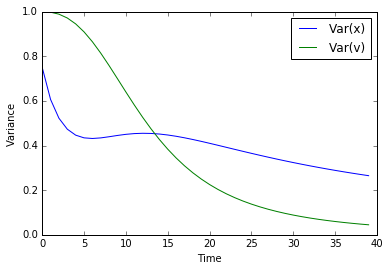

In [21]:
# Plot variances of x and v, extracting the appropriate values from the covariance matrix
plt.plot(times, state_covs[:,0,0])
plt.plot(times, state_covs[:,1,1])
plt.legend(['Var(x)', 'Var(v)'])
plt.ylabel('Variance')
plt.xlabel('Time');

The Kalman filter can also do <i>smoothing</i>, which takes in all of the input data at once and then constructs its best guess for the state of the system in each period post factum. That is, it does not provide online, running estimates, but instead uses all of the data to estimate the historical state, which is useful if we only want to use the data after we have collected all of it.

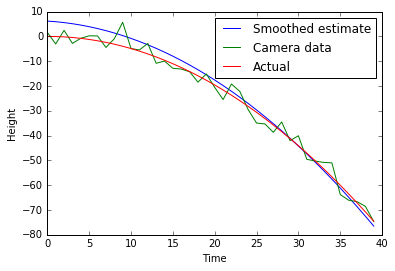

In [22]:
# Use smoothing to estimate what the state of the system has been
smoothed_state_means, _ = kf.smooth(sim)

# Plot results
plt.plot(times, smoothed_state_means[:,0])
plt.plot(times, sim)
plt.plot(times, actual)
plt.legend(['Smoothed estimate', 'Camera data', 'Actual'])
plt.xlabel('Time')
plt.ylabel('Height');

# Example: moving average

Because the Kalman filter updates its estimates at every time step and tends to weigh recent observations more than older ones, a particularly useful application is estimation of rolling parameters of the data. When using a Kalman filter, there's no window length that we need to specify. This is useful for computing the moving average if that's what we are interested in, or for smoothing out estimates of other quantities. For instance, if we have already computed the moving Sharpe ratio, we can smooth it using a Kalman filter.

Below, we'll use both a Kalman filter and an n-day moving average to estimate the rolling mean of a dataset. We hope that the mean describes our observations well, so it shouldn't change too much when we add an observation; therefore, we assume that it evolves as a random walk with a small error term. The mean is the model's guess for the mean of the distribution from which measurements are drawn, so our prediction of the next value is simply equal to our estimate of the mean. We assume that the observations have variance 1 around the rolling mean, for lack of a better estimate. Our initial guess for the mean is 0, but the filter quickly realizes that that is incorrect and adjusts.

In [23]:
df = pd.read_csv("../data/ChungCheonDC/CompositeETCdata.csv")
df_DC = pd.read_csv("../data/ChungCheonDC/CompositeDCdata.csv")
df_DCstd = pd.read_csv("../data/ChungCheonDC/CompositeDCstddata.csv")

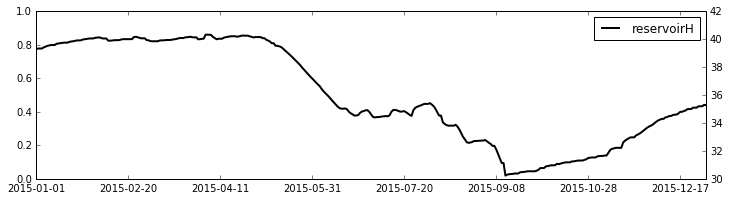

In [24]:
ax1 = plt.subplot(111)
ax1_1 = ax1.twinx()
df.plot(figsize=(12,3), x='date', y='reservoirH', ax=ax1_1, color='k', linestyle='-', lw=2)

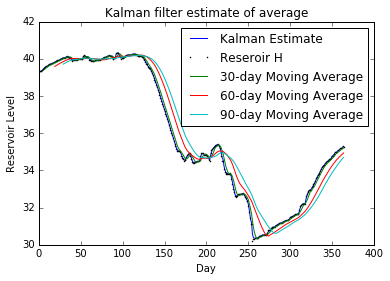

In [25]:
# Load pricing data for a security
# start = '2013-01-01'
# end = '2015-01-01'
#x = get_pricing('reservoirH', fields='price', start_date=start, end_date=end)
x= df.reservoirH
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 39.3,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=1)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(x.values)

# Compute the rolling mean with various lookback windows
mean10 = pd.rolling_mean(x, 6)
mean20 = pd.rolling_mean(x, 20)
mean30 = pd.rolling_mean(x, 30)

# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(x, 'k.', ms=2)
plt.plot(mean10)
plt.plot(mean20)
plt.plot(mean30)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'Reseroir H', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Reservoir Level');

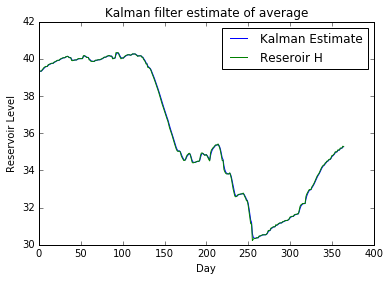

In [26]:
plt.plot(state_means)
plt.plot(x)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'Reseroir H'])
plt.xlabel('Day')
plt.ylabel('Reservoir Level');

This is a little hard to see, so we'll plot a subsection of the graph.

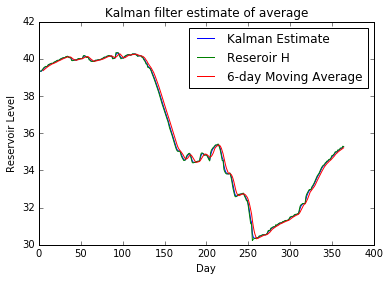

In [27]:
plt.plot(state_means[-400:])
plt.plot(x[-400:])
plt.plot(mean10[-400:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'Reseroir H', '6-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Reservoir Level');

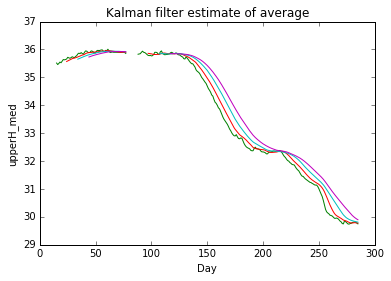

In [28]:
# Load pricing data for a security
# start = '2013-01-01'
# end = '2015-01-01'
#x = get_pricing('reservoirH', fields='price', start_date=start, end_date=end)
xH= df.upperH_med
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 35.5,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(xH.values)

# Compute the rolling mean with various lookback windows
mean10 = pd.rolling_mean(xH, 10)
mean20 = pd.rolling_mean(xH, 20)
mean30 = pd.rolling_mean(xH, 30)

# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(xH)
plt.plot(mean10)
plt.plot(mean20)
plt.plot(mean30)
plt.title('Kalman filter estimate of average')
# plt.legend(['Kalman Estimate', 'upperH_med', '10-day Moving Average', '20-day Moving Average','30-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('upperH_med');

In [208]:
txrxID =  df_DC.keys()[1:-1]
xmasking = lambda x: np.ma.masked_where(np.isnan(x.values), x.values) 

In [242]:
x= df_DC[txrxID[150]]
median10 = pd.rolling_median(x, 6)
mean10 = pd.rolling_max(x, 3)
x1 = median10
x2 = mean10
# Masking array having NaN
xm = xmasking(x2)
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 67.6,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=1)
# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(xm)

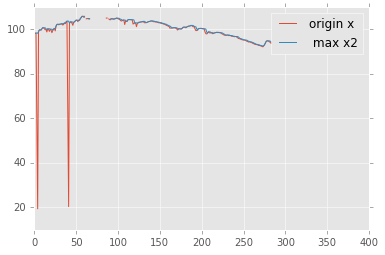

In [243]:
#plt.plot(x1) 
plt.plot(x)
#plt.plot(x1) 
plt.plot(x2)
#plt.plot(state_means) 
plt.legend([ 'origin x',' max x2', 'Kalman Estimate'])

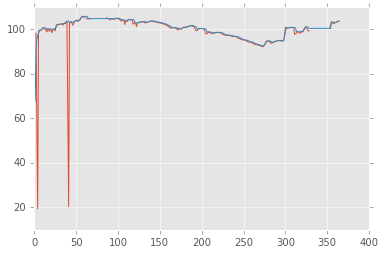

In [244]:
plt.plot(x)
plt.plot(state_means)

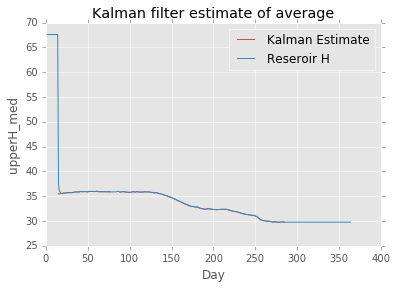

In [245]:
upperH_med = xmasking(df.upperH_med)
state_means, _ = kf.filter(upperH_med)

plt.plot(df.upperH_med)
plt.plot(state_means)

# plt.plot(xH)
# plt.plot(mean10)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'Reseroir H','10-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('upperH_med');

In [109]:
# Import libraries
%matplotlib inline
import pandas as pd
import sys

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

plt.style.use('ggplot')
np.random.seed(20)

In [184]:
#x = df.reservoirH
x =df_DC[txrxID[2]]

In [185]:
mean10 = pd.rolling_max(x, 4)

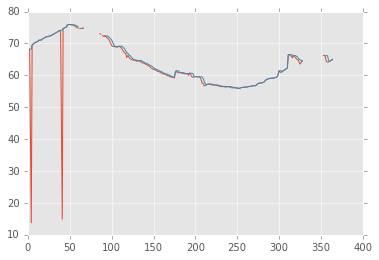

In [186]:
plt.plot(x)
plt.plot(mean10)

In [135]:
#-------------------------------------------------------------------------------
# Set up

# Time
t = np.linspace(0,1,100)

# Frequencies in the signal
f1 = 20
f2 = 30

# Some random noise to add to the signal
noise = np.random.random_sample(len(t))

# Complete signal
y = x #2*np.sin(2*np.pi*f1*t+0.2) + 3*np.cos(2*np.pi*f2*t+0.3) + noise*5

# The part of the signal we want to isolate
y1 = x #2*np.sin(2*np.pi*f1*t+0.2)


In [136]:
y

0      67.69065
1      67.99035
2      68.25520
3      41.14775
4      13.76705
5      69.57090
6      69.72875
7      69.97565
8      70.15050
9      70.38895
10     70.47380
11     70.52660
12     70.71980
13     71.03690
14     71.00625
15     71.05955
16     71.12500
17     71.33380
18     71.57365
19     71.64240
20     71.85690
21     71.99350
22     72.00340
23     72.15140
24     72.23385
25     72.28900
26     72.34930
27     72.40260
28     72.60380
29     72.72585
         ...   
335         NaN
336         NaN
337         NaN
338         NaN
339         NaN
340         NaN
341         NaN
342         NaN
343         NaN
344         NaN
345         NaN
346         NaN
347         NaN
348         NaN
349         NaN
350         NaN
351    66.07475
352         NaN
353    66.23685
354    66.25100
355    66.06395
356    64.88725
357    64.24260
358    64.17610
359    64.17000
360    64.35285
361    64.45750
362    64.73035
363    64.83395
364    65.01635
Name: 4356, dtype: float

In [137]:
# FFT of the signal
F = sc.fft(y)

# Other specs
N = len(t)                              # number of samples
dt = 0.001                              # inter-sample time difference
w = np.fft.fftfreq(N, dt)               # list of frequencies for the FFT
pFrequency = np.where(w>=0)[0]          # we only positive frequencies
magnitudeF = abs(F[:len(pFrequency)])   # magnitude of F for the positive frequencies

#-------------------------------------------------------------------------------
# Some functions we will need


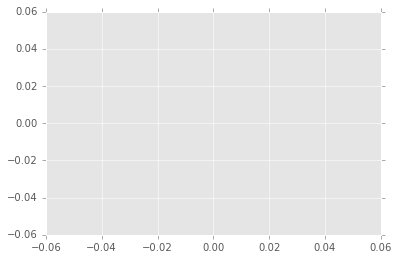

In [138]:
plt.plot(F)

In [116]:
print F

[  1.16153914e+04 +0.00000000e+00j  -1.35725953e+02 -3.71578290e+03j
  -2.30503626e+02 -1.46764106e+03j  -1.15891991e+02 -9.16095740e+02j
  -6.38915857e+01 -8.94700809e+02j  -3.80955286e+01 -5.69654724e+02j
  -2.91970029e+01 -5.40230971e+02j  -2.37043823e+01 -4.55351692e+02j
   1.09157296e+00 -3.98882761e+02j   1.21556220e+01 -3.44408983e+02j
  -1.32490170e+01 -3.01779316e+02j  -1.79428798e+00 -3.01804129e+02j
   1.81734266e+01 -2.46973850e+02j  -5.45918758e+00 -2.37618131e+02j
   9.37053027e+00 -2.34423844e+02j   1.27883951e+01 -2.07009251e+02j
  -9.96018337e-02 -1.91390964e+02j   3.26257752e+00 -1.88068916e+02j
   7.23535070e+00 -1.72241393e+02j   1.07940335e+01 -1.56718415e+02j
  -1.26200858e+00 -1.58272701e+02j   1.93789927e+01 -1.56448579e+02j
   6.28658609e+00 -1.31073796e+02j   5.79802619e+00 -1.42763927e+02j
   1.52235451e+01 -1.26905662e+02j   6.03132614e+00 -1.25249565e+02j
   1.01772823e+01 -1.15284086e+02j   1.01147358e+01 -1.15819934e+02j
   1.03820530e+01 -1.11149910e+02j

In [139]:
# Plots the FFT
def pltfft():
    plt.plot(pFrequency,magnitudeF)
    plt.xlabel('Hz')
    plt.ylabel('Magnitude')
    plt.title('FFT of the full signal')
    plt.grid(True)
    plt.show()

# Plots the full signal
def pltCompleteSignal():
    plt.plot(t,y,'b')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Full signal')
    plt.grid(True)
    plt.show()

In [140]:
# Filter function:
# blocks higher frequency than fmax, lower than fmin and returns the cleaned FT
def blockHigherFreq(FT,fmin,fmax,plot=False):
    for i in range(len(F)):
        if (i>= fmax) or (i<=fmin):
            FT[i] = 0
    if plot:
        plt.plot(pFrequency,abs(FT[:len(pFrequency)]))
        plt.xlabel('Hz')
        plt.ylabel('Magnitude')
        plt.title('Cleaned FFT')
        plt.grid(True)
        plt.show()
    return FT

# Normalising function (gets the signal in a scale from 0 to 1)
def normalise(signal):
    M = max(signal)
    normalised = signal/M
    return normalised

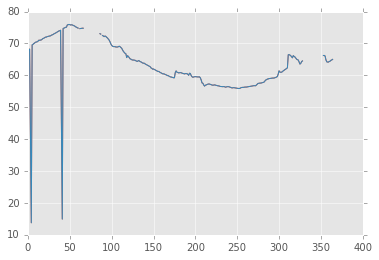

In [141]:
plt.plot(y)
plt.plot(y1)

In [145]:
print F

[  0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j  nan+nanj  nan+nanj
  nan+nanj   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j   0. +0.j
   0. 

In [142]:
#-------------------------------------------------------------------------------
# Processing

# Cleaning the FT by selecting only frequencies between 18 and 22
newFT = blockHigherFreq(F,18,22)

# Getting back the cleaned signal
cleanedSignal = sc.ifft(F)

# Error
error = normalise(y1) - normalise(cleanedSignal)


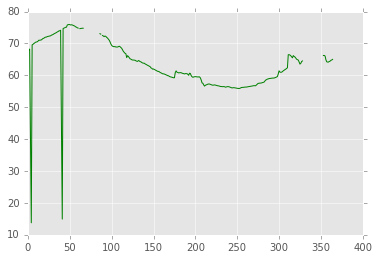

In [143]:
plt.plot(y,'g')

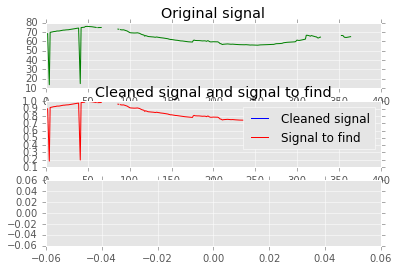

In [144]:
#
#-------------------------------------------------------------------------------
# Plot the findings

#pltCompleteSignal()         #Plot the full signal
#pltfft()                    #Plot fft

plt.figure()

plt.subplot(3,1,1)          #Subplot 1
plt.title('Original signal')
plt.plot(y,'g')

plt.subplot(3,1,2)          #Subplot 2
plt.plot(normalise(cleanedSignal),label='Cleaned signal',color='b')
plt.plot(normalise(y1),label='Signal to find',ls='-',color='r')
plt.title('Cleaned signal and signal to find')
plt.legend()

plt.subplot(3,1,3)          #Subplot 3
plt.plot(error,color='r',label='error')
plt.show()

In [92]:
% Signal parameters:
#f = [ 440 880 1000 2000 ];      % frequencies
#M = 256;                        % signal length
#Fs = 5000;                      % sampling rate

% Generate a signal by adding up sinusoids:
x = zeros(1,M); % pre-allocate 'accumulator'
n = 0:(M-1);    % discrete-time grid
#for fk = f;
    x = df.reservoirH ;
#end

SyntaxError: invalid syntax (<ipython-input-92-2dd45d0bfe9c>, line 7)

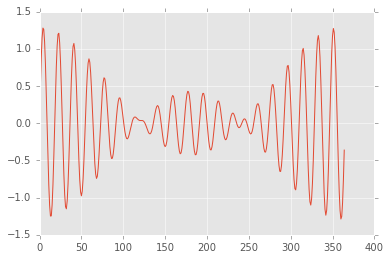

In [125]:
plt. plot(sc.ifft(F))


In [94]:
 yy = df.reservoirH 
    #yyy = df.reservoirH   
    print x

IndentationError: unexpected indent (<ipython-input-94-e52c1a9e912b>, line 3)

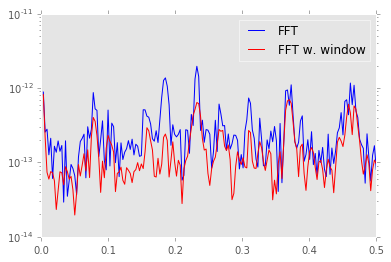

In [72]:
from scipy.fftpack import fft
# Number of sample points
N = 364
# sample spacing
T = 1.0
x = np.linspace(1, N*T, N)
#y = df.reservoirH*x #np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

yf = fft(y)
from scipy.signal import blackman
w = blackman(N)
ywf = fft(y*w)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
import matplotlib.pyplot as plt
plt.semilogy(xf[1:N/2], 2.0/N * np.abs(yf[1:N/2]), '-b')
plt.semilogy(xf[1:N/2], 2.0/N * np.abs(ywf[1:N/2]), '-r')
plt.legend(['FFT', 'FFT w. window'])
plt.grid()
plt.show()

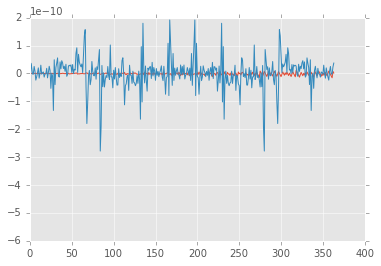

In [73]:
plt.plot(y)
plt.plot(yf)

In [74]:
print y

[ -7.83278767e-15  -1.56655753e-14  -1.37185201e-13  -3.13311507e-14
   7.45228994e-14  -2.74370401e-13   5.88573240e-14  -6.26623014e-14
  -1.84181927e-13   1.49045799e-13   2.75261734e-14  -5.48740803e-13
  -2.15513077e-13   1.17714648e-13  -4.58552328e-13  -1.25324603e-13
   2.07903123e-13  -3.68363853e-13  -3.51361280e-14   2.98091597e-13
  -2.78175379e-13   5.50523467e-14   3.88280072e-13  -1.09748161e-12
  -7.64253880e-13  -4.31026155e-13  -9.77984294e-14   2.35429296e-13
  -1.25033238e-12  -9.17104656e-13  -5.83876931e-13  -2.50649205e-13
  -8.26916182e-13   4.15806246e-13  -1.60460731e-13  -7.36727707e-13
  -1.31299468e-12  -7.02722560e-14  -6.46539232e-13   5.96183195e-13
   1.99162187e-14  -5.56350758e-13  -1.13261773e-12   1.10104693e-13
  -4.66162283e-13   7.76560144e-13   2.00293168e-13  -2.19496321e-12
  -9.52240784e-13  -1.52850776e-12  -2.85785333e-13  -8.62052310e-13
   3.80670118e-13  -1.95596859e-13   1.04712557e-12   4.70858592e-13
   1.71358102e-12  -2.50066476e-12

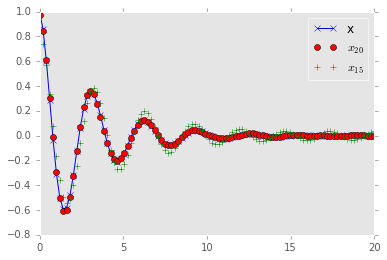

In [60]:
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
N = 100
t = np.linspace(0,20,N)
x = np.exp(-t/3)*np.cos(2*t)
y = dct(x, norm='ortho')
window = np.zeros(N)
window[:20] = 1
yr = idct(y*window, norm='ortho')
sum(abs(x-yr)**2) / sum(abs(x)**2)
# 0.0010901402257
plt.plot(t, x, '-bx')
plt.plot(t, yr, 'ro')
window = np.zeros(N)
window[:15] = 1
yr = idct(y*window, norm='ortho')
sum(abs(x-yr)**2) / sum(abs(x)**2)
# 0.0718818065008
plt.plot(t, yr, 'g+')
plt.legend(['x', '$x_{20}$', '$x_{15}$'])
plt.grid()
plt.show()

In [70]:
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
N = 364
t = np.linspace(0,1,N)
x = df.reservoirH #np.exp(-t/3)*np.cos(2*t)
y = dct(x, norm='ortho')
window = np.zeros(N)
window[:20] = 1
yr = idct(y*window, norm='ortho')
sum(abs(x-yr)**2) / sum(abs(x)**2)
# 0.0010901402257
plt.plot(t, x, '-bx')
plt.plot(t, yr, 'ro')
window = np.zeros(N)
window[:15] = 1
yr = idct(y*window, norm='ortho')
sum(abs(x-yr)**2) / sum(abs(x)**2)
# 0.0718818065008
plt.plot(t, yr, 'g+')
plt.legend(['x', '$x_{20}$', '$x_{15}$'])
plt.grid()
plt.show()

ValueError: operands could not be broadcast together with shapes (365,) (364,) 